<a href="https://colab.research.google.com/github/chefdarek/DS-Unit-1-Sprint-4-Statistical-Tests-and-Experiments/blob/master/LS_DS4_142_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [0]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [0]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=35.459377549287545, pvalue=1.99569421909769e-08)


In [0]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## Live Lecture - let's explore some more of scipy.stats

Candidate topics to explore:

- `scipy.stats.chi2` - the Chi-squared distribution, which we can use to reproduce the Chi-squared test
- Calculate the Chi-Squared test statistic "by hand" (with code), and feed it into `chi2`
- Build a confidence interval with `stats.t.ppf`, the t-distribution percentile point function (the inverse of the CDF) - we can write a function to return a tuple of `(mean, lower bound, upper bound)` that you can then use for the assignment (visualizing confidence intervals)

In [0]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head(20)

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [0]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
country            583
salary               0
dtype: int64

In [0]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [0]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [0]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [0]:
cut_points = [0,9,19,29,39,49,1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [0]:
data = df[['sex', 'hours_per_week_categories']]
data.head()

,sex,hours_per_week_categories
0,Male,40-49
1,Male,10-19
2,Male,40-49
3,Male,40-49
4,Female,40-49


In [0]:
data['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

Before we calculate our contingency table, lets make very clear what our null and alternative hypotheses are in this situation. 

$H_{0}$ : There is *no* statistically significant relationship between gender and working hours per week.

$H_{a}$ : There *is* a statistically significant relationship between gender and working hours per week.

In [0]:
# contingency_table = pd.crosstab(data['sex'], data['hours_per_week_categories'], margins=True, normalize=True)
contingency_table = pd.crosstab(data['sex'], data['hours_per_week_categories'], margins=True)

contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,6462,1246,18336,3667,458,2392,32561


In [0]:
femalecount = contingency_table.iloc[0][0:6].values
femalecount

array([ 235,  671, 1287, 1914, 5636, 1028])

In [0]:
malecount = contingency_table.iloc[1][0:6].values
malecount

array([  223,   575,  1105,  1753, 12700,  5434])

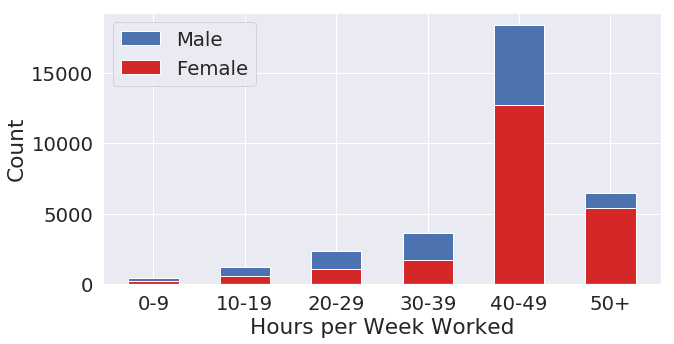

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

#Plots the bar chart
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=1.8)
categories = ["0-9","10-19","20-29","30-39","40-49","50+"]
p1 = plt.bar(categories, malecount, 0.55, color='#d62728')
p2 = plt.bar(categories, femalecount, 0.55, bottom=malecount)
plt.legend((p2[0], p1[0]), ('Male', 'Female'))
plt.xlabel('Hours per Week Worked')
plt.ylabel('Count')
plt.show()

### Expected Value Calculation
\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [0]:
# Get Row Sums
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values

print(row_sums)
print(col_sums)

[10771 21790]
[ 6462  1246 18336  3667   458  2392]


In [0]:
total = contingency_table.loc['All', 'All']
print(total)

expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
print(np.array(expected))

# print(np.array(expected).T[0].sum())

32561
[[ 2137.59411566   412.16995793  6065.44811277  1213.02346365
    151.50388502   791.26046497]
 [ 4324.40588434   833.83004207 12270.55188723  2453.97653635
    306.49611498  1600.73953503]]


## Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [0]:
contingency = pd.crosstab(data['sex'],
                          data['hours_per_week_categories'])
contingency = contingency.values

print(contingency.shape)
print(contingency)

(2, 6)
[[  235   671  1287  1914  5636  1028]
 [  223   575  1105  1753 12700  5434]]


In [0]:
chi_squared = ((contingency - expected)**2/(expected)).sum()
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 729291.9658823247


In [0]:
# Calculate Degrees of Freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")                        

Degrees of Freedom: 5


In [0]:
# Calculate the p-value from the chi_squared and dof
p_value = stats.chi2.sf(2287.19, dof)
print(f"P-value: {p_value}")

P-value: 0.0


In [0]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(contingency)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Confidence Intervals

In [0]:
import scipy.stats as stats
import numpy as np

#confidence_interval = [lower_bound, upper_bound]

coinflips = np.random.binomial(n=1, p=.7, size=100)
print(coinflips)

[1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1
 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1
 1 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0]


In [0]:
stats.ttest_1samp(coinflips, .5)

Ttest_1sampResult(statistic=2.243949409710865, pvalue=0.027062805092371137)

In [0]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
coinflips_1000 = np.random.binomial(n=1, p=.5, size=1000)

print("100 Coinflips Standard Deviation:", np.std(coinflips_100))
print("1000 Coinflips Standard Deviation:", np.std(coinflips_1000))

100 Coinflips Standard Deviation: 0.4963869458396343
1000 Coinflips Standard Deviation: 0.4999509975987647


In [0]:
print("100 Coinflips Standard Error:", stats.sem(coinflips_100))
print("1000 Coinflips Standard :", stats.sem(coinflips_1000))

100 Coinflips Standard Error: 0.04988876515698589
1000 Coinflips Standard : 0.01581774956184353


In [0]:
0.4995998398718718/np.sqrt(100)

0.04995998398718718

In [0]:
0.4998039615689336/np.sqrt(1000)

0.015805189021330938

In [0]:
# Confidence intervals!
# Similar to hypothesis testing, but centered at sample mean
# Generally better than reporting the "point estimate" (sample mean)
# Why? Because point estimates aren't always perfect

import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

def report_confidence_interval(confidence_interval):
  """
  Return a string with a pretty report of a confidence interval.
  
  Arguments:
    confidence_interval - tuple of (mean, lower bound, upper bound)
  
  Returns:
    None, but prints to screen the report
  """
  #print('Mean: {}'.format(confidence_interval[0]))
  #print('Lower bound: {}'.format(confidence_interval[1]))
  #print('Upper bound: {}'.format(confidence_interval[2]))
  s = "our mean lies in the interval [{:.2}, {:.2}]".format(
      confidence_interval[1], confidence_interval[2])
  return s

In [0]:
stats.t.ppf(0.1, 99)

-1.2901614420275023

In [0]:
(1+.95)/2.0

0.975

In [0]:
coinflips = np.random.binomial(n=1, p=.5, size=100)
# print(coinflips)

In [0]:
coinflip_interval = confidence_interval(coinflips)  # Default 95% conf
coinflip_interval

(0.57, 0.47127134651887564, 0.6687286534811242)

In [0]:
def get_100_coinflips():
  return np.random.binomial(n=1, p=.5, size=100)

for i in range(0,100):
  # 100 Coinflips
  coinflips = get_100_coinflips()
  # Calculate Confidence Interval
  coinflip_interval = confidence_interval(coinflips)
  # Report Confidence Interval
  print('Mean: {}'.format(coinflip_interval[0]))
  print('Lower bound: {}'.format(coinflip_interval[1]))
  print('Upper bound: {}'.format(coinflip_interval[2]))

Mean: 0.46
Lower bound: 0.3606089327527314
Upper bound: 0.5593910672472686
Mean: 0.49
Lower bound: 0.3903092906280824
Upper bound: 0.5896907093719176
Mean: 0.46
Lower bound: 0.3606089327527314
Upper bound: 0.5593910672472686
Mean: 0.55
Lower bound: 0.4507891524245659
Upper bound: 0.6492108475754341
Mean: 0.41
Lower bound: 0.31191795947468715
Upper bound: 0.5080820405253128
Mean: 0.6
Lower bound: 0.5023039108049319
Upper bound: 0.6976960891950681
Mean: 0.5
Lower bound: 0.400289346502771
Upper bound: 0.599710653497229
Mean: 0.5
Lower bound: 0.400289346502771
Upper bound: 0.599710653497229
Mean: 0.51
Lower bound: 0.4103092906280824
Upper bound: 0.6096907093719176
Mean: 0.5
Lower bound: 0.400289346502771
Upper bound: 0.599710653497229
Mean: 0.51
Lower bound: 0.41030929062808247
Upper bound: 0.6096907093719175
Mean: 0.4
Lower bound: 0.30230391080493196
Upper bound: 0.4976960891950681
Mean: 0.52
Lower bound: 0.4203691469585294
Upper bound: 0.6196308530414707
Mean: 0.57
Lower bound: 0.4712713

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):

1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [0]:
from scipy import stats
import scipy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from matplotlib import style



In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data')

In [0]:
df.columns =[
    "Class",
    'handy_inf',
    'water_project',
    'budget_res',
    'physician_fee',
    'el_salv',
    'religion_sch',
    'anti_sat_test',
    'nic_aid',
    'mx_missle',
    'immigration',
    'synfules',
    'education',
    'superfund',
    'crime',
    'duty-free',
    's_africa',
    
]



df.describe()


,Class,handy_inf,water_project,budget_res,physician_fee,el_salv,religion_sch,anti_sat_test,nic_aid,mx_missle,immigration,synfules,education,superfund,crime,duty-free,s_africa
count,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434,434
unique,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,235,194,253,247,211,271,239,242,207,215,264,233,208,247,232,268


In [0]:
df2 = df.iloc[0:434].replace("n", -1).replace("y",1).replace("?",0)

In [0]:
df2.head()

,Class,handy_inf,water_project,budget_res,physician_fee,el_salv,religion_sch,anti_sat_test,nic_aid,mx_missle,immigration,synfules,education,superfund,crime,duty-free,s_africa
0,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,0
1,democrat,0,1,1,0,1,1,-1,-1,-1,-1,1,-1,1,1,-1,-1
2,democrat,-1,1,1,-1,0,1,-1,-1,-1,-1,1,-1,1,-1,-1,1
3,democrat,1,1,1,-1,1,1,-1,-1,-1,-1,1,0,1,1,1,1
4,democrat,-1,1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1


In [0]:
df2.set_index("Class")

,handy_inf,water_project,budget_res,physician_fee,el_salv,religion_sch,anti_sat_test,nic_aid,mx_missle,immigration,synfules,education,superfund,crime,duty-free,s_africa
Class,,,,,,,,,,,,,,,,
republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,0
democrat,0,1,1,0,1,1,-1,-1,-1,-1,1,-1,1,1,-1,-1
democrat,-1,1,1,-1,0,1,-1,-1,-1,-1,1,-1,1,-1,-1,1
democrat,1,1,1,-1,1,1,-1,-1,-1,-1,1,0,1,1,1,1
democrat,-1,1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1
democrat,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,0,1,1,1
republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,1,0,1
republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,1
democrat,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,-1,-1,0,0


In [0]:
cols  = list(df2.columns.values)
cols

['Class',
 'handy_inf',
 'water_project',
 'budget_res',
 'physician_fee',
 'el_salv',
 'religion_sch',
 'anti_sat_test',
 'nic_aid',
 'mx_missle',
 'immigration',
 'synfules',
 'education',
 'superfund',
 'crime',
 'duty-free',
 's_africa']

In [0]:
df2.shape

(434, 17)

In [0]:
democrats = df2[df2['Class'] == 'democrat']


In [0]:
d_melt = pd.melt(democrats, id_vars='Class', value_name='Votes', var_name='Issue')
d_melt.columns = ['Democrat', 'Issue', 'Votes']

In [0]:
ds = pd.crosstab(d_melt.Issue,d_melt.Votes)

In [0]:
ds.head()

Votes,-1,0,1
Issue,,,
anti_sat_test,59,8,200
budget_res,29,7,231
crime,167,10,90
duty-free,91,16,160
education,213,18,36


In [0]:
republican = df2[df2['Class'] == 'republican']
republican.head()

,Class,handy_inf,water_project,budget_res,physician_fee,el_salv,religion_sch,anti_sat_test,nic_aid,mx_missle,immigration,synfules,education,superfund,crime,duty-free,s_africa
0,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,0
6,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,-1,1,1,0,1
7,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,-1,1,1,1,-1,1
9,republican,-1,1,-1,1,1,-1,-1,-1,-1,-1,0,0,1,1,-1,-1
10,republican,-1,1,-1,1,1,1,-1,-1,-1,-1,1,0,1,1,0,0


In [0]:
reps_melt = pd.melt(republican, id_vars='Class', value_name='Votes', var_name='Issue')
reps_melt.columns = ['Republicans', 'Issue', 'Votes']

In [0]:
repz = pd.crosstab(reps_melt.Issue,reps_melt.Votes)

In [0]:
repz

Votes,-1,0,1
Issue,,,
anti_sat_test,122,6,39
budget_res,141,4,22
crime,3,7,157
duty-free,141,12,14
education,20,13,134
el_salv,8,3,156
handy_inf,133,3,31
immigration,73,3,91
mx_missle,145,3,19


In [0]:
import numpy as np
from scipy import stats

def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (f'Mean:{mean}, Lower:{mean - interval},Upper:{mean + interval}')
#   confidence_int = (mean, mean - interval, mean + interval)
#   return (list(confidence_int))

In [0]:
for x in cols[1:]:
  print(f"{str.upper(x)}, {confidence_interval(democrats[x])}")


 

HANDY_INF, Mean:0.20224719101123595, Lower:0.08611576858125876,Upper:0.31837861344121315
WATER_PROJECT, Mean:0.003745318352059925, Lower:-0.11047087500416793,Upper:0.11796151170828777
BUDGET_RES, Mean:0.7565543071161048, Lower:0.680068480081707,Upper:0.8330401341505027
PHYSICIAN_FEE, Mean:-0.8651685393258427, Lower:-0.9219877336288015,Upper:-0.8083493450228839
EL_SALV, Mean:-0.5430711610486891, Lower:-0.6411561313420852,Upper:-0.4449861907552931
RELIGION_SCH, Mean:-0.0449438202247191, Lower:-0.16349000602567465,Upper:0.07360236557623644
ANTI_SAT_TEST, Mean:0.5280898876404494, Lower:0.427726202568374,Upper:0.6284535727125248
NIC_AID, Mean:0.6479400749063671, Lower:0.5571818661013366,Upper:0.7386982837113976
MX_MISSLE, Mean:0.4794007490636704, Lower:0.37846833459834,Upper:0.5803331635290009
IMMIGRATION, Mean:-0.056179775280898875, Lower:-0.17580234143603218,Upper:0.06344279087423443
SYNFULES, Mean:0.011235955056179775, Lower:-0.10673457160769645,Upper:0.129206481720056
EDUCATION, Mean:-0

In [0]:
for x in cols[1:]:
  print(f"{str.upper(x)}, {confidence_interval(republican[x])}")


HANDY_INF, Mean:-0.6107784431137725, Lower:-0.7303630629532493,Upper:-0.4911938232742957
WATER_PROJECT, Mean:0.005988023952095809, Lower:-0.13778036097582513,Upper:0.14975640888001673
BUDGET_RES, Mean:-0.7125748502994012, Lower:-0.8174389723396333,Upper:-0.607710728259169
PHYSICIAN_FEE, Mean:0.9580838323353293, Lower:0.9192831740437717,Upper:0.996884490626887
EL_SALV, Mean:0.8862275449101796, Lower:0.8182752607570162,Upper:0.9541798290633431
RELIGION_SCH, Mean:0.7844311377245509, Lower:0.6908805128122124,Upper:0.8779817626368893
ANTI_SAT_TEST, Mean:-0.49700598802395207, Lower:-0.6267683131229533,Upper:-0.3672436629249508
NIC_AID, Mean:-0.6467065868263473, Lower:-0.7567731868460905,Upper:-0.5366399868066041
MX_MISSLE, Mean:-0.7544910179640718, Lower:-0.8529444198734303,Upper:-0.6560376160547133
IMMIGRATION, Mean:0.10778443113772455, Lower:-0.04317189892826011,Upper:0.2587407612037092
SYNFULES, Mean:-0.7005988023952096, Lower:-0.8046730673706328,Upper:-0.5965245374197863
EDUCATION, Mean:

In [0]:
def confidence_interval_list(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  confidence_int = (mean, mean - interval, mean + interval)
  return (list(confidence_int))

In [0]:
import matplotlib.pyplot as plt

In [0]:
confidence_interval(ds)

'Mean:89.0, Lower:[52.32839728 79.10210209 54.58194313],Upper:[125.67160272  98.89789791 123.41805687]'

''

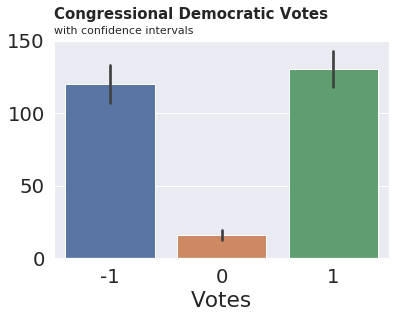

In [0]:
ax = sns.barplot(data=ds, ci=55.6)
title = "Congressional Democratic Votes"
subtitle = "with confidence intervals"
ax.text(x=-.5, y=165, s=title,
          fontsize=15, fontweight='bold')
ax.text(x=-.5, y=155, s=subtitle,
          fontsize=11)
;

In [0]:
confidence_interval(repz)

'Mean:55.666666666666664, Lower:[24.53150937 52.36535589 24.4723637 ],Upper:[86.80182396 58.96797744 86.86096963]'

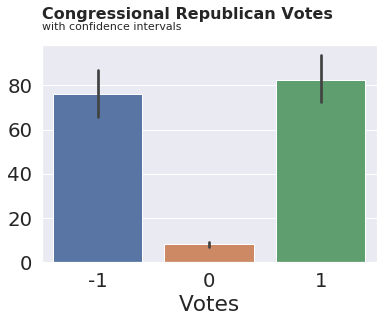

In [0]:
ax = sns.barplot(data=repz, ci=55.6)
title = "Congressional Republican Votes"
subtitle = "with confidence intervals"
ax.text(x=-.5, y=110, s=title,
          fontsize=16, fontweight='bold')
ax.text(x=-.5, y=105, s=subtitle,
          fontsize=11);

In [0]:
list(ds.index)

['anti_sat_test',
 'budget_res',
 'crime',
 'duty-free',
 'education',
 'el_salv',
 'handy_inf',
 'immigration',
 'mx_missle',
 'nic_aid',
 'physician_fee',
 'religion_sch',
 's_africa',
 'superfund',
 'synfules',
 'water_project']

In [0]:
ds.iloc[0][0:2].values

array([59,  8])

In [0]:
repz.shape
ds.head()
ds.index

Index(['anti_sat_test', 'budget_res', 'crime', 'duty-free', 'education',
       'el_salv', 'handy_inf', 'immigration', 'mx_missle', 'nic_aid',
       'physician_fee', 'religion_sch', 's_africa', 'superfund', 'synfules',
       'water_project'],
      dtype='object', name='Issue')

In [0]:
#   ax = sns.barplot(x=repz[0][1:],y=repz ci=55.6)
#   title = "Congressional Republican Votes"
#   subtitle = "with confidence intervals"
#   ax.text(x=-.5, y=105, s=title,
#             fontsize=15, fontweight='bold')
#   ax.text(x=-.5, y=100, s=subtitle,
#             fontsize=11)
#   plt.show();

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)